In [3]:
import torch

In [4]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [5]:
import timm
from pprint import pprint
model_names = timm.list_models('*vit*t*')
pprint(model_names)

['convit_tiny',
 'crossvit_tiny_240',
 'gcvit_tiny',
 'gcvit_xtiny',
 'gcvit_xxtiny',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxxvit_rmlp_tiny_rw_256',
 'mobilevitv2_150_384_in22ft1k',
 'mobilevitv2_150_in22ft1k',
 'mobilevitv2_175_384_in22ft1k',
 'mobilevitv2_175_in22ft1k',
 'mobilevitv2_200_384_in22ft1k',
 'mobilevitv2_200_in22ft1k',
 'mvitv2_tiny',
 'vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base

In [6]:
vit_tiny_patch16_384 = timm.create_model("vit_tiny_patch16_384", pretrained=True)

In [7]:
# vit_tiny_patch16_384

In [8]:
state_dict = vit_tiny_patch16_384.state_dict()


In [9]:
W_qkv = state_dict["blocks.10.attn.qkv.weight"].t()  # Transpose to split correctly
# Splitting the combined matrix to get individual matrices for each head
W_q, W_k, W_v = torch.chunk(W_qkv, 3, dim=1)  # Split along the column dimension

# Since there are 3 heads, we further split each matrix along the row dimension
W_qs = torch.chunk(W_q, 3, dim=0)
W_ks = torch.chunk(W_k, 3, dim=0)
W_vs = torch.chunk(W_v, 3, dim=0)

W_proj = state_dict["blocks.0.attn.proj.weight"]
# Split W_proj along its column dimension
W_projs = torch.chunk(W_proj, 3, dim=0)


In [32]:
W_proj.shape

torch.Size([192, 192])

In [33]:
W_vs[i].shape

torch.Size([64, 192])

In [34]:
W_projs[i].shape

torch.Size([192, 64])

In [44]:
torch.mm(W_vs[i], W_proj.t()).shape

torch.Size([64, 192])

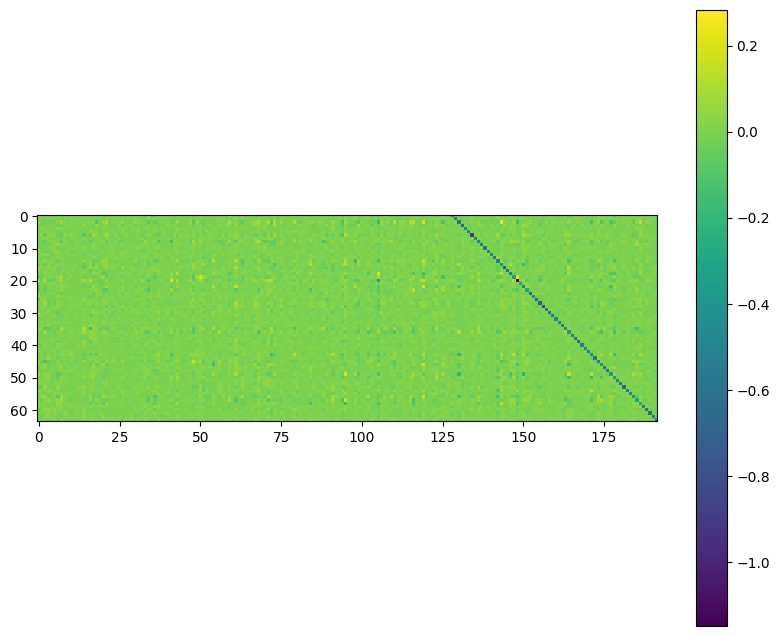

In [39]:
visualize_matrix(torch.mm(W_vs[i], W_proj.t()))

In [47]:
W_proj.shape

torch.Size([192, 192])

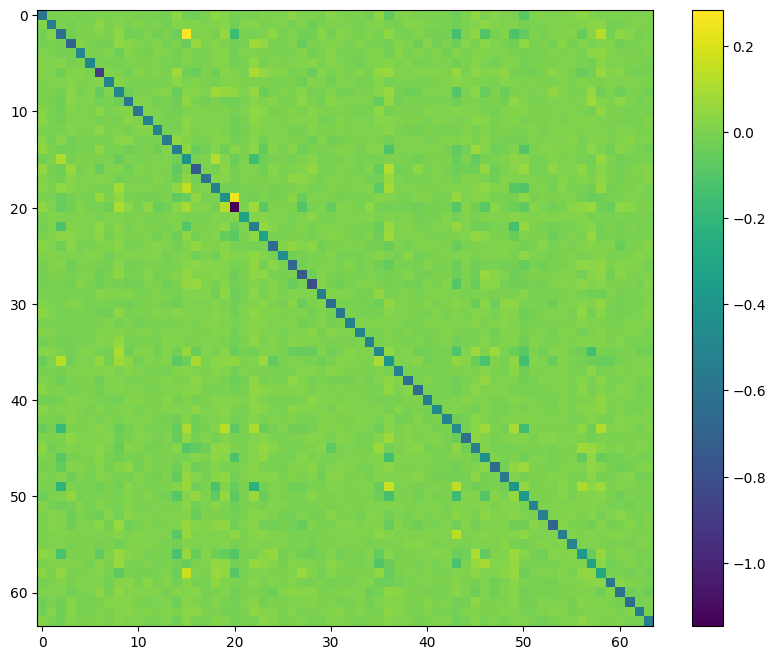

In [51]:
visualize_matrix(torch.mm(W_vs[2], W_proj[-64:].t()))

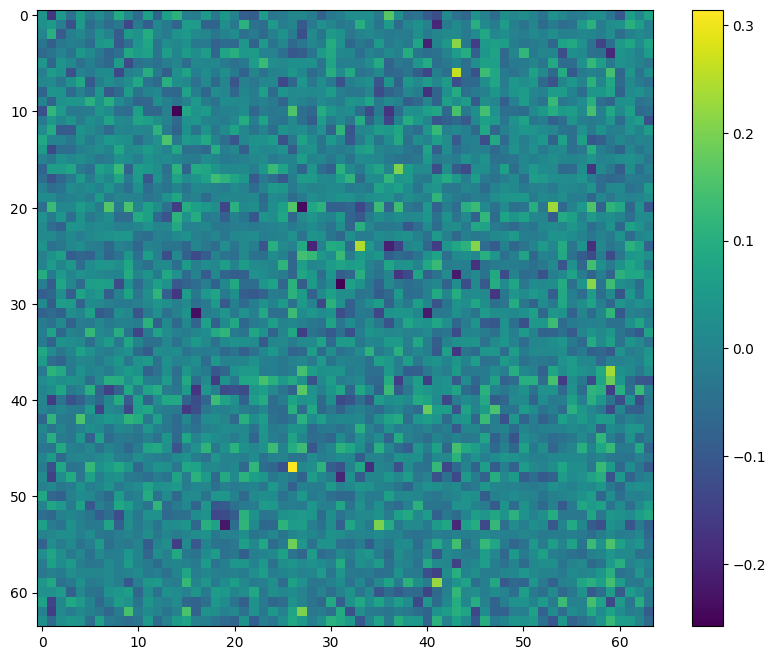

In [52]:
visualize_matrix(torch.mm(W_vs[2], W_projs[2]))

In [43]:
torch.mm(W_vs[i], W_projs[i]).shape

torch.Size([64, 64])

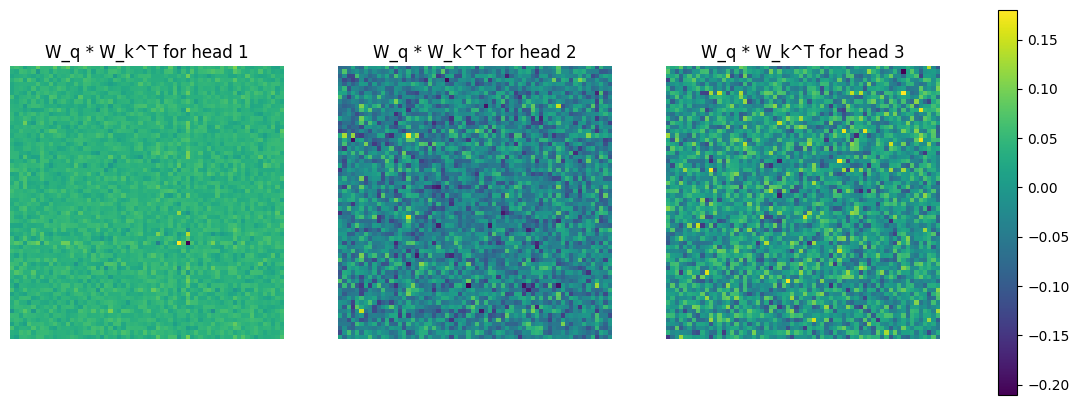

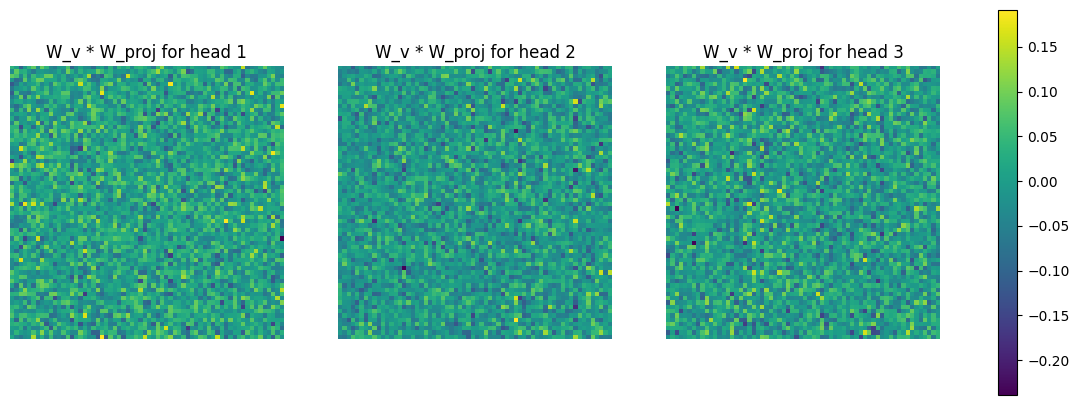

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_matrices_side_by_side(matrices, titles):
    fig, axes = plt.subplots(1, len(matrices), figsize=(15, 5))
    for ax, matrix, title in zip(axes, matrices, titles):
        ax.imshow(matrix, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.colorbar(axes[-1].imshow(matrices[-1], cmap='viridis'), ax=axes.ravel().tolist())
    plt.show()

# Compute W_q * W_k^T for each head
matrix_q_k = [torch.mm(W_qs[i], W_ks[i].t()).detach().numpy() for i in range(3)]

visualize_matrices_side_by_side(matrix_q_k, [f"W_q * W_k^T for head {i+1}" for i in range(3)])

matrix_v_proj = [torch.mm(W_vs[i], W_projs[i].t()).detach().numpy() for i in range(3)]
visualize_matrices_side_by_side(matrix_v_proj, [f"W_v * W_proj for head {i+1}" for i in range(3)])

# Compute the sum of W_v * W_proj for all heads
# matrix_v_proj_sum = sum([torch.mm(W_vs[i], W_projs[i]).detach().numpy() for i in range(3)])
# plt.figure(figsize=(10, 8))
# plt.imshow(matrix_v_proj_sum, cmap='viridis')
# plt.title("Sum of W_v * W_proj over all heads")
# plt.colorbar()
# plt.show()


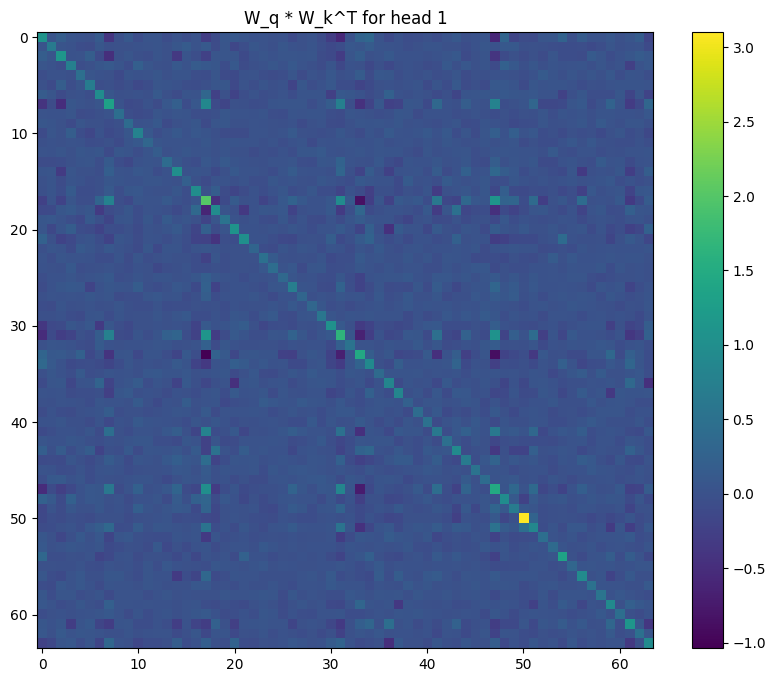

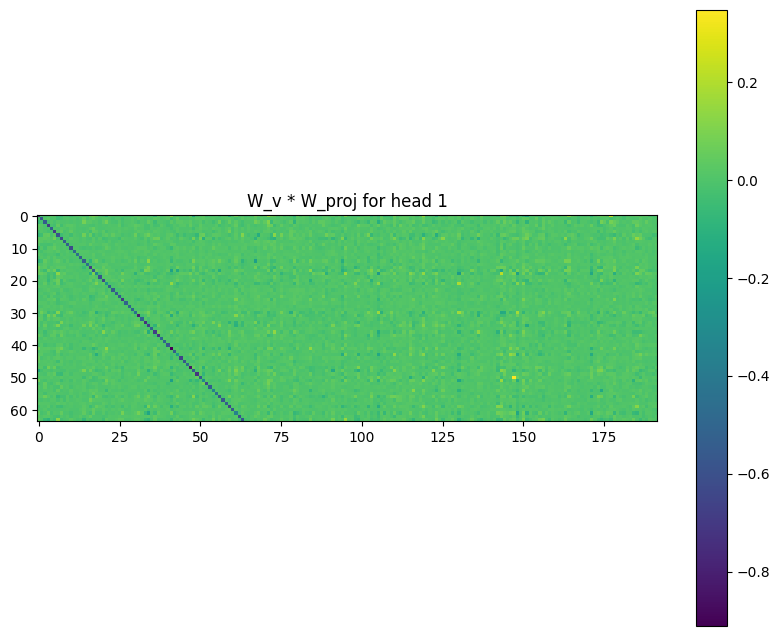

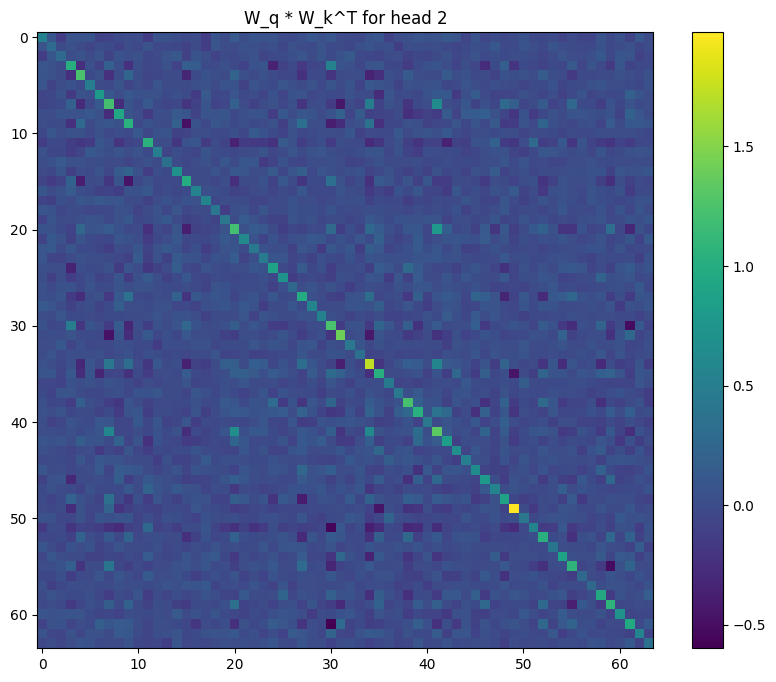

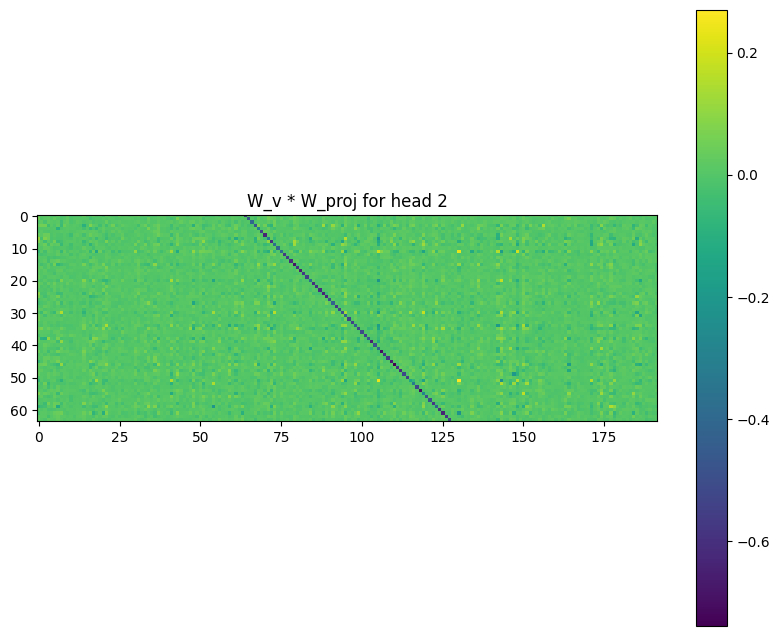

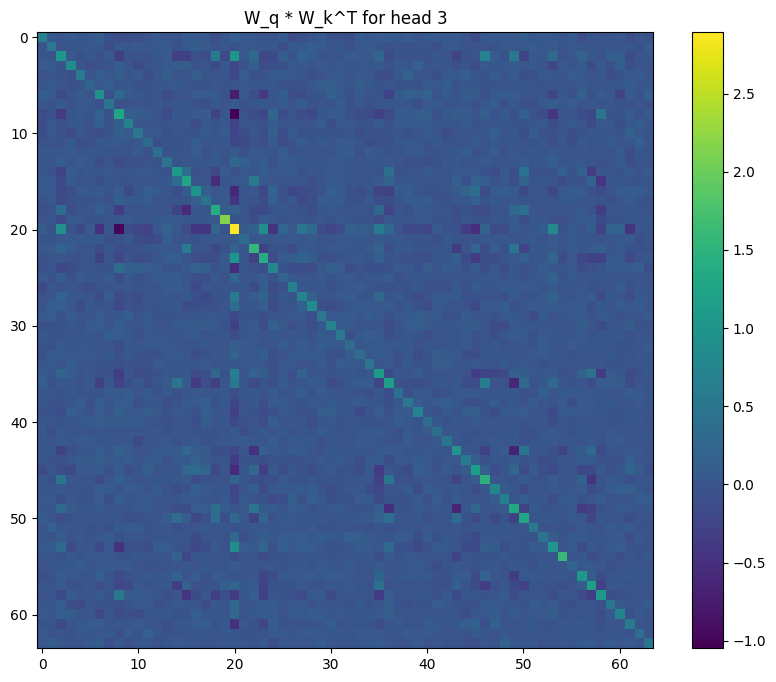

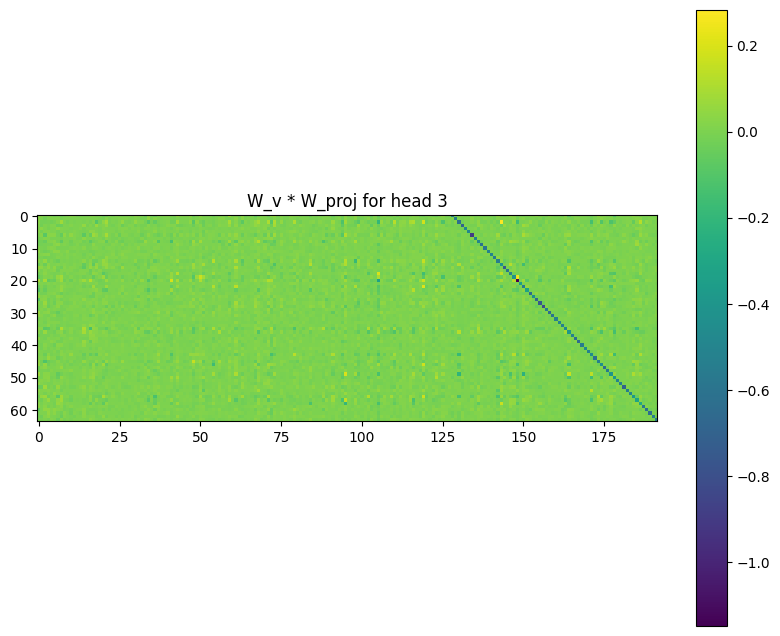

In [27]:
import matplotlib.pyplot as plt

def visualize_matrix(matrix, title=""):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.imshow(matrix, cmap='viridis')
    plt.colorbar()
    plt.show()

# For each head, compute and visualize the matrices
for i in range(3):
    matrix_q_k = torch.mm(W_qs[i], W_ks[i].t())
    matrix_v_proj = torch.mm(W_vs[i], W_proj.t())

    visualize_matrix(matrix_q_k.detach().numpy(), title=f"W_q * W_k^T for head {i+1}")
    visualize_matrix(matrix_v_proj.detach().numpy(), title=f"W_v * W_proj for head {i+1}")


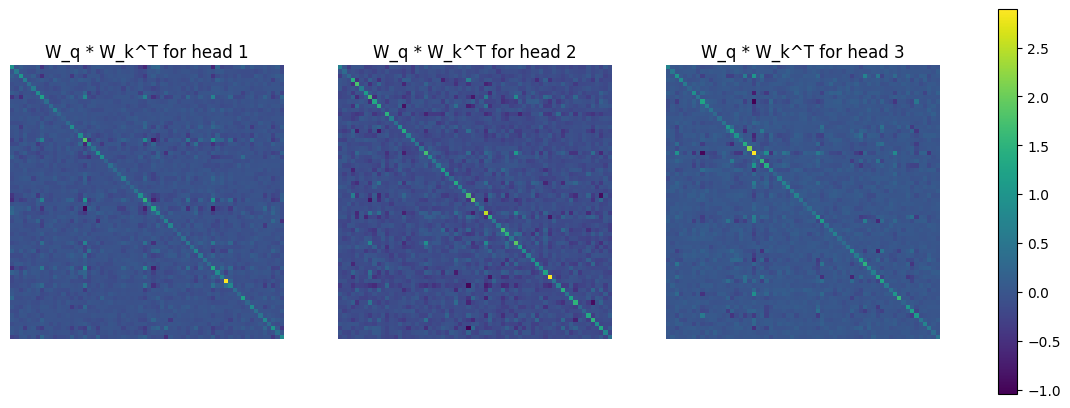

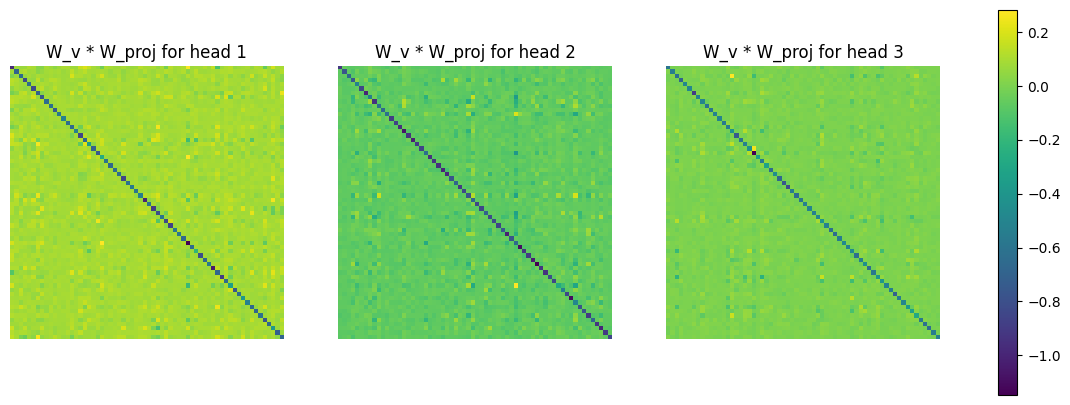

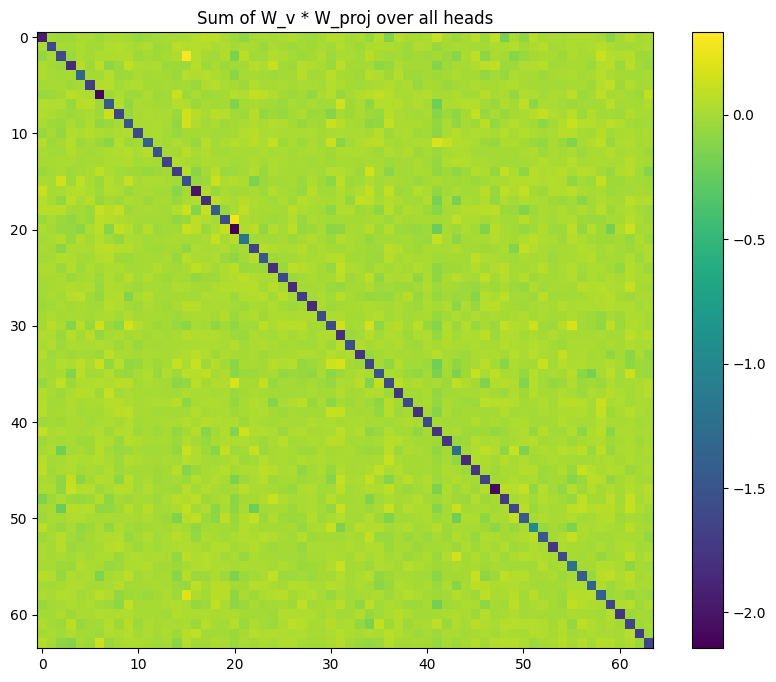

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_matrices_side_by_side(matrices, titles):
    fig, axes = plt.subplots(1, len(matrices), figsize=(15, 5))
    for ax, matrix, title in zip(axes, matrices, titles):
        ax.imshow(matrix, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.colorbar(axes[-1].imshow(matrices[-1], cmap='viridis'), ax=axes.ravel().tolist())
    plt.show()

# Compute W_q * W_k^T for each head
matrix_q_k = [torch.mm(W_qs[i], W_ks[i].t()).detach().numpy() for i in range(3)]

visualize_matrices_side_by_side(matrix_q_k, [f"W_q * W_k^T for head {i+1}" for i in range(3)])

matrix_v_proj = [torch.mm(W_vs[i], W_projs[i].t()).detach().numpy() for i in range(3)]
visualize_matrices_side_by_side(matrix_v_proj, [f"W_v * W_proj for head {i+1}" for i in range(3)])

# Compute the sum of W_v * W_proj for all heads
matrix_v_proj_sum = sum([torch.mm(W_vs[i], W_projs[i].t()).detach().numpy() for i in range(3)])
plt.figure(figsize=(10, 8))
plt.imshow(matrix_v_proj_sum, cmap='viridis')
plt.title("Sum of W_v * W_proj over all heads")
plt.colorbar()
plt.show()

### 12 blocks together

In [11]:
# Initialize containers for all blocks' weights
W_q_all, W_k_all, W_v_all, W_proj_all = [], [], [], []

for block_idx in range(12):
    prefix = f"blocks.{block_idx}.attn."

    W_qkv = state_dict[prefix + "qkv.weight"].t()  # Transpose for splitting
    W_q, W_k, W_v = torch.chunk(W_qkv, 3, dim=1)
    W_q_all.append(torch.chunk(W_q, 3, dim=0))
    W_k_all.append(torch.chunk(W_k, 3, dim=0))
    W_v_all.append(torch.chunk(W_v, 3, dim=0))
    W_proj_all.append(torch.chunk(state_dict[prefix + "proj.weight"], 3, dim=0))


In [16]:
W_proj_all[0][0].shape

torch.Size([64, 192])

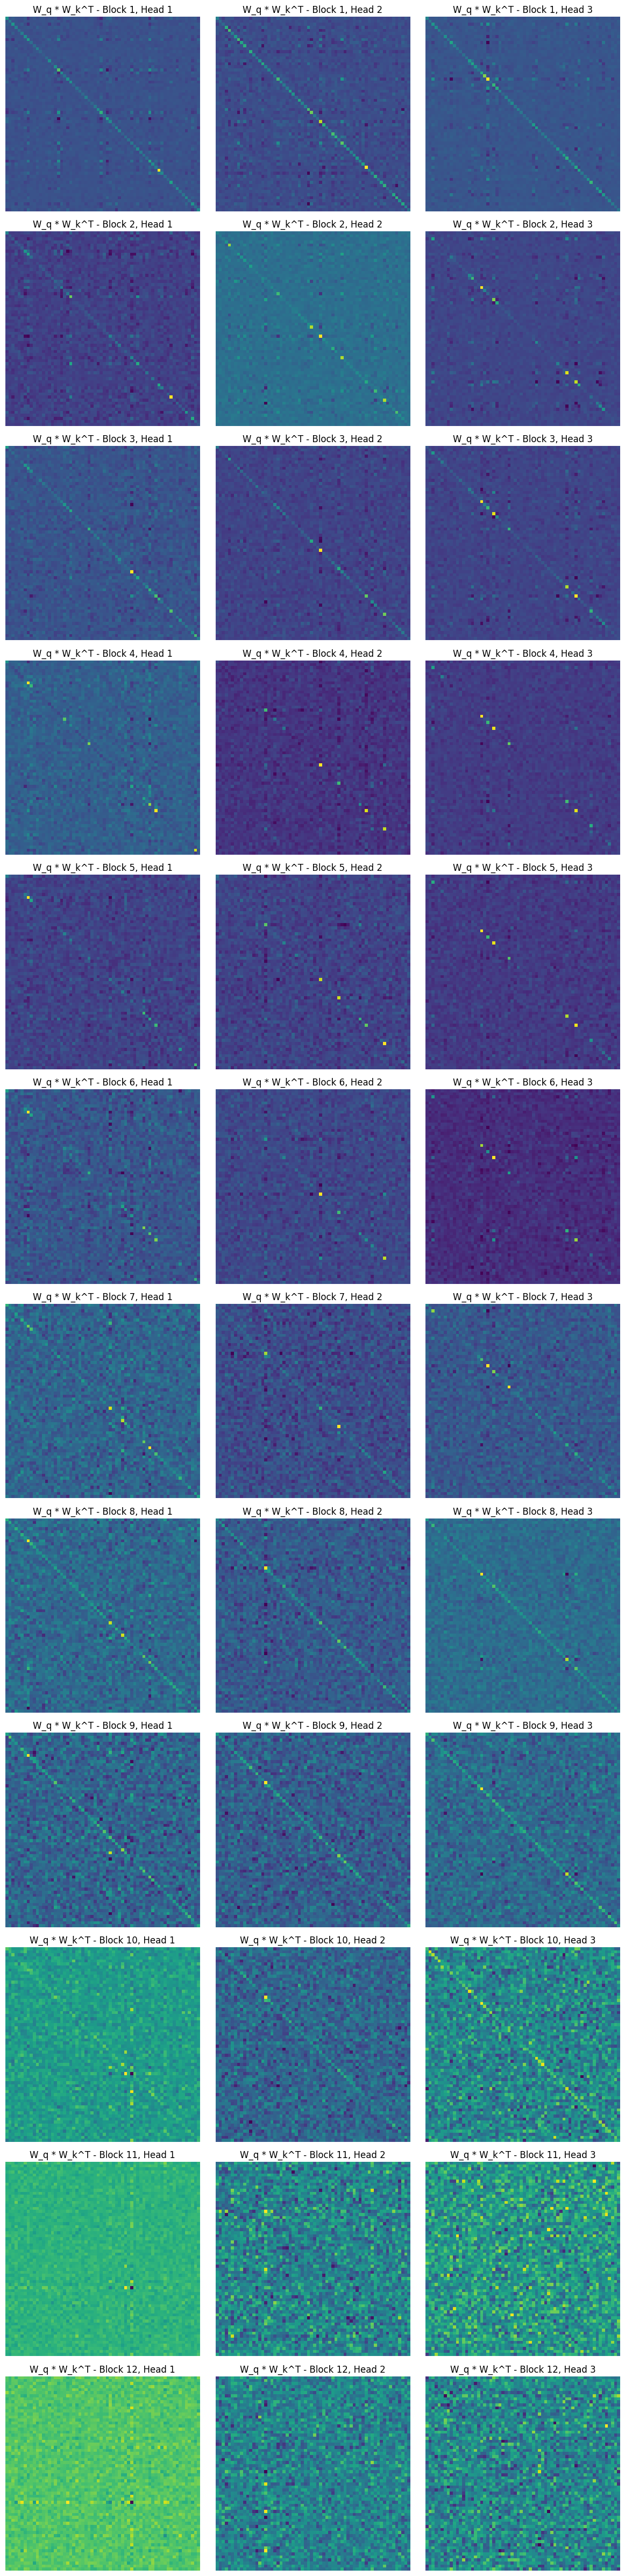

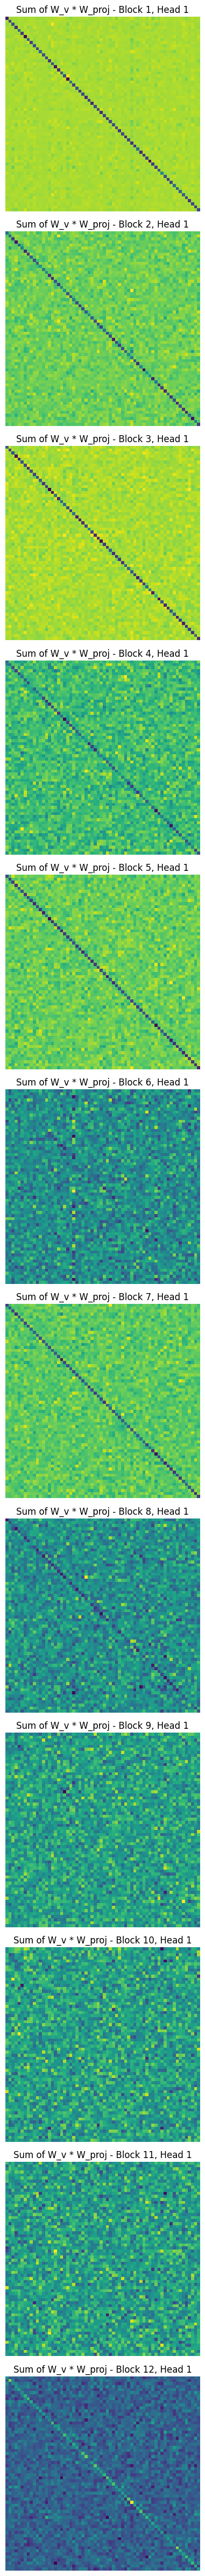

In [20]:
def visualize_matrices_grid(matrices, title_prefix, ncols=3):
    nblocks, nheads = len(matrices), len(matrices[0])
    fig, axes = plt.subplots(nblocks, nheads, figsize=(4*ncols, 4*nblocks))
    
    for block_idx in range(nblocks):
        for head_idx in range(nheads):
            if nblocks > 1:
                if nheads > 1:
                    ax = axes[block_idx, head_idx]
                else:
                    ax = axes[block_idx]
            else:
                ax = axes[head_idx]
            ax.imshow(matrices[block_idx][head_idx], cmap='viridis')
            ax.set_title(f"{title_prefix} - Block {block_idx+1}, Head {head_idx+1}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

matrix_q_k_all = [[torch.mm(W_q_all[block][head], W_k_all[block][head].t()).detach().numpy() 
                   for head in range(3)] 
                  for block in range(12)]
visualize_matrices_grid(matrix_q_k_all, "W_q * W_k^T")

matrix_v_proj_sum_all = [sum([torch.mm(W_v_all[block][head], W_proj_all[block][head].t()).detach().numpy() 
                              for head in range(3)]) 
                         for block in range(12)]
visualize_matrices_grid([[matrix] for matrix in matrix_v_proj_sum_all], 
                        "Sum of W_v * W_proj", ncols=1)
